In [1]:
from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
from dask.dataframe.utils import make_meta
import matplotlib.pyplot as plt 
import numpy as np  
import lsdb
import pandas as pd
from catalog_filtering import bandFilterLenient, contains_PM

In [2]:
bandList = ['G','R','I','Z','Y']
class_star = None
spread_model = 0.05
magnitude_error = 0.05
check_flags = True
check_invalid_mags = True
query_string = bandFilterLenient(bandList,classStar=class_star,spreadModel=spread_model,magError=magnitude_error,flag=check_flags,invalidMags=check_invalid_mags)
des_cols = (
    [f'CLASS_STAR_{band}' for band in bandList] + 
    [f'FLAGS_{band}' for band in bandList] + 
    ['RA','DEC','COADD_OBJECT_ID'] + 
    [f'SPREAD_MODEL_{band}' for band in bandList] + 
    [f'WAVG_MAG_PSF_{band}' for band in bandList] + 
    [f'WAVG_MAGERR_PSF_{band}' for band in bandList]
)
des_gaia_xmatch = lsdb.read_hipscat('/Volumes/PSC/des_gaia_xmatch/')
k = 1
collinear_error_cutoff = 0.2
pm_speed_min = 2000 #units are milliseconds per year
pm_speed_max = 10**5
cone_search_rad = 50
max_neighbor_dist = 18
milliarc_degree_conversion = 1/(1000*3600)

In [3]:
pm_filter_xmatch = des_gaia_xmatch.query(f'{pm_speed_max**2} >(pmra_gaia**2 + pmdec_gaia**2) > {pm_speed_min**2}')
with Client():
    df = pm_filter_xmatch.compute()

df

,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,FLAGS_G_des,FLAGS_R_des,FLAGS_I_des,FLAGS_Z_des,FLAGS_Y_des,...,WAVG_MAGERR_PSF_I_des,WAVG_MAGERR_PSF_Z_des,WAVG_MAGERR_PSF_Y_des,ra_gaia,pmra_gaia,dec_gaia,pmdec_gaia,source_id_gaia,parallax_over_error_gaia,_dist_arcsec
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
4613930437209751552,0.84542,0.845421,0.845413,0.845344,0.035287,19,19,19,19,19,...,-99.0,-99.0,-99.0,1.383284,5633.438088,-37.367744,-2334.721273,2306965202564744064,6359.301,1.786142
5030074573559693312,0.844564,0.845075,0.845251,0.843732,0.801461,2,2,2,2,2,...,-99.0,-99.0,-99.0,33.079599,-1762.405718,3.567385,-1852.8711,2515037264041041536,3857.4338,1.62095
9473310124119425024,0.048989,0.404167,0.99414,0.02865,0.028268,3,3,3,3,3,...,0.000554,-99.0,-99.0,53.567196,2360.592206,-49.890084,483.127504,4736655036868019072,2020.9392,2.582885
9473310124769542144,0.717914,0.984056,0.848698,0.544428,0.028628,3,3,3,3,3,...,-99.0,-99.0,-99.0,53.567196,2360.592206,-49.890084,483.127504,4736655036868019072,2020.9392,4.575273
9560201318102990848,0.125803,0.120065,0.028601,0.028627,0.028627,3,3,3,3,3,...,-99.0,-99.0,-99.0,62.611,-825.17937,-53.612997,-2415.577565,4780100658292046592,6581.664,4.490123
9560201322498621440,0.644246,0.036391,0.842178,0.788,0.034785,3,3,3,3,3,...,-99.0,-99.0,-99.0,62.611,-825.17937,-53.612997,-2415.577565,4780100658292046592,6581.664,4.672577
9695914633298182144,0.845425,0.845425,0.845406,0.845371,0.84513,22,22,18,18,22,...,-99.0,-99.0,-99.0,50.000344,3035.017316,-43.066553,726.964482,4847957293278177024,2112.3093,0.825611
9800217929181036544,0.844839,0.845014,0.845117,0.845267,0.844982,2,2,2,2,6,...,-99.0,-99.0,-99.0,5.03561,1706.746855,-64.869617,1164.959443,4900108950849461248,871.1839,3.096527
9874001828230725632,0.84536,0.029197,0.845341,0.842975,0.047746,2,3,2,2,2,...,-99.0,-99.0,-99.0,32.622946,2125.416147,-50.820906,637.975043,4937000898856156288,2016.6344,0.425698


In [4]:
df_no_dupes = df[~df['source_id_gaia'].duplicated(keep='first')]

gaia_ids = df_no_dupes['source_id_gaia']

#dropping because otherwise produces error when performing .apply below
df_no_dupes = df_no_dupes.drop('source_id_gaia', axis=1)

df_no_dupes

,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,FLAGS_G_des,FLAGS_R_des,FLAGS_I_des,FLAGS_Z_des,FLAGS_Y_des,...,WAVG_MAGERR_PSF_R_des,WAVG_MAGERR_PSF_I_des,WAVG_MAGERR_PSF_Z_des,WAVG_MAGERR_PSF_Y_des,ra_gaia,pmra_gaia,dec_gaia,pmdec_gaia,parallax_over_error_gaia,_dist_arcsec
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
4613930437209751552,0.84542,0.845421,0.845413,0.845344,0.035287,19,19,19,19,19,...,-99.0,-99.0,-99.0,-99.0,1.383284,5633.438088,-37.367744,-2334.721273,6359.301,1.786142
5030074573559693312,0.844564,0.845075,0.845251,0.843732,0.801461,2,2,2,2,2,...,-99.0,-99.0,-99.0,-99.0,33.079599,-1762.405718,3.567385,-1852.8711,3857.4338,1.62095
9473310124119425024,0.048989,0.404167,0.99414,0.02865,0.028268,3,3,3,3,3,...,0.001941,0.000554,-99.0,-99.0,53.567196,2360.592206,-49.890084,483.127504,2020.9392,2.582885
9560201318102990848,0.125803,0.120065,0.028601,0.028627,0.028627,3,3,3,3,3,...,-99.0,-99.0,-99.0,-99.0,62.611,-825.17937,-53.612997,-2415.577565,6581.664,4.490123
9695914633298182144,0.845425,0.845425,0.845406,0.845371,0.84513,22,22,18,18,22,...,-99.0,-99.0,-99.0,-99.0,50.000344,3035.017316,-43.066553,726.964482,2112.3093,0.825611
9800217929181036544,0.844839,0.845014,0.845117,0.845267,0.844982,2,2,2,2,6,...,-99.0,-99.0,-99.0,-99.0,5.03561,1706.746855,-64.869617,1164.959443,871.1839,3.096527
9874001828230725632,0.84536,0.029197,0.845341,0.842975,0.047746,2,3,2,2,2,...,-99.0,-99.0,-99.0,-99.0,32.622946,2125.416147,-50.820906,637.975043,2016.6344,0.425698
9874001828230725632,0.84536,0.029197,0.845341,0.842975,0.047746,2,3,2,2,2,...,-99.0,-99.0,-99.0,-99.0,32.624069,2168.886011,-50.820823,710.847727,588.3757,2.199757
10012464071594475520,0.036971,0.466729,0.943789,0.983893,0.035059,3,3,3,3,3,...,0.003359,0.003134,0.002709,0.008519,11.341389,1826.373986,-33.497993,-1485.010343,166.26512,4.295977


In [5]:
def distance_to_line(line_vector, PQ):
    return np.abs(np.cross(PQ, line_vector)) / np.linalg.norm(line_vector)

def within_collinear_error(line_vector, PQ, error):
    return (distance_to_line(line_vector, PQ) <= error)

def kth_star_min_distance(group, k, cols_to_keep):
    origin_ra, origin_dec = group['RA_1'], group['DEC_1']
    ra2, dec2 = group[["RA_2", "DEC_2"]].to_numpy().T
    
    x_vals = (ra2 - origin_ra) * np.cos(np.radians(origin_dec)) * 3600
    y_vals = (dec2 - origin_dec) * 3600
    delta_coords = np.vstack((x_vals, y_vals)).T

    kth_distances = [None] * len(delta_coords)

    for i in range(len(delta_coords)):
        proj_vector = delta_coords[i]
        distances = []

        if np.all(proj_vector == 0): continue #ensures vector points to a point that is not the origin

        for j in range(len(delta_coords)):
            if np.all(delta_coords[j] == 0) or (j == i): continue
            
            distances.append(distance_to_line(proj_vector, delta_coords[j]))

        kth_distances[i] = sorted(distances)[k]
    
    group['kth_min_proj_error'] = kth_distances

    return group[cols_to_keep + ['kth_min_proj_error']]

def algo_found_pm(row, des_cols, cone_search_rad, query_string, max_neighbor_dist, k, collinear_error_cutoff):
    filtered_catalog = (
        lsdb.read_hipscat('/Volumes/PSC/des_dr2_light/', columns=des_cols)
        .cone_search(ra=row['ra_gaia'], dec=row['dec_gaia'], radius_arcsec=cone_search_rad)
        .query(query_string)
    )

    xmatch = filtered_catalog.crossmatch(filtered_catalog, n_neighbors=100, radius_arcsec=max_neighbor_dist, suffixes=['_1', '_2'])
    xmatch_ddf = xmatch._ddf

    neighbors = xmatch_ddf.groupby('_hipscat_index')['_dist_arcsec'].count()
    neighbors -= 1 #Double counting adjustment
    neighbors.name = 'neighbors'
    xmatch_ddf = xmatch_ddf.join(neighbors, on='_hipscat_index')
    xmatch_large_groups = xmatch_ddf.query('neighbors >= 3')
    columns_to_keep = (
        [col for col in xmatch_large_groups.columns if col.endswith('_2')]
    )

    meta = make_meta(xmatch_large_groups[columns_to_keep])
    meta['kth_min_proj_error'] = 0.0
    star_groups = xmatch_large_groups.groupby('_hipscat_index').apply(kth_star_min_distance, meta=meta, k=k-1, cols_to_keep = columns_to_keep)  
    df = star_groups.compute().reset_index(drop=True, level = 0)

    
    return bool(not (df.query(f'kth_min_proj_error < {collinear_error_cutoff}').empty))



In [6]:
df_no_dupes['algo_found'] = df_no_dupes.apply(func=algo_found_pm, axis=1, des_cols=des_cols, cone_search_rad=cone_search_rad, query_string=query_string, max_neighbor_dist=max_neighbor_dist, k=k, collinear_error_cutoff=collinear_error_cutoff)
df_no_dupes['source_id_gaia'] = gaia_ids
df_no_dupes

/Users/johnpassos/Documents/LSDB/venv/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:108: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
/Users/johnpassos/Documents/LSDB/venv/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:108: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
/Users/johnpassos/Documents/LSDB/venv/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:108: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
/Users/johnpassos/Documents/LSDB/venv/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:108: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
/Users/johnpassos/Documents/LSDB/venv/lib/python3.11/site-packages/lsdb/dask

,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,FLAGS_G_des,FLAGS_R_des,FLAGS_I_des,FLAGS_Z_des,FLAGS_Y_des,...,WAVG_MAGERR_PSF_Z_des,WAVG_MAGERR_PSF_Y_des,ra_gaia,pmra_gaia,dec_gaia,pmdec_gaia,parallax_over_error_gaia,_dist_arcsec,algo_found,source_id_gaia
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
4613930437209751552,0.84542,0.845421,0.845413,0.845344,0.035287,19,19,19,19,19,...,-99.0,-99.0,1.383284,5633.438088,-37.367744,-2334.721273,6359.301,1.786142,False,2306965202564744064
5030074573559693312,0.844564,0.845075,0.845251,0.843732,0.801461,2,2,2,2,2,...,-99.0,-99.0,33.079599,-1762.405718,3.567385,-1852.8711,3857.4338,1.62095,False,2515037264041041536
9473310124119425024,0.048989,0.404167,0.99414,0.02865,0.028268,3,3,3,3,3,...,-99.0,-99.0,53.567196,2360.592206,-49.890084,483.127504,2020.9392,2.582885,True,4736655036868019072
9560201318102990848,0.125803,0.120065,0.028601,0.028627,0.028627,3,3,3,3,3,...,-99.0,-99.0,62.611,-825.17937,-53.612997,-2415.577565,6581.664,4.490123,False,4780100658292046592
9695914633298182144,0.845425,0.845425,0.845406,0.845371,0.84513,22,22,18,18,22,...,-99.0,-99.0,50.000344,3035.017316,-43.066553,726.964482,2112.3093,0.825611,False,4847957293278177024
9800217929181036544,0.844839,0.845014,0.845117,0.845267,0.844982,2,2,2,2,6,...,-99.0,-99.0,5.03561,1706.746855,-64.869617,1164.959443,871.1839,3.096527,False,4900108950849461248
9874001828230725632,0.84536,0.029197,0.845341,0.842975,0.047746,2,3,2,2,2,...,-99.0,-99.0,32.622946,2125.416147,-50.820906,637.975043,2016.6344,0.425698,False,4937000898856156288
9874001828230725632,0.84536,0.029197,0.845341,0.842975,0.047746,2,3,2,2,2,...,-99.0,-99.0,32.624069,2168.886011,-50.820823,710.847727,588.3757,2.199757,False,4937000898856154624
10012464071594475520,0.036971,0.466729,0.943789,0.983893,0.035059,3,3,3,3,3,...,0.002709,0.008519,11.341389,1826.373986,-33.497993,-1485.010343,166.26512,4.295977,True,5006232026455470848


In [10]:
df_no_dupes.to_csv('algo_gaia_verified.csv')

In [7]:
def plot_pms_helper(df, check_column, cone_search_rad, title_prefix):
    df_loop = df[df[check_column]] if title_prefix == 'Found' else df[~df[check_column]]
    # Get the number of rows that meet the condition
    rows_count = df_loop.shape[0]
    
    # Create subplots
    fig, axs = plt.subplots(rows_count, 1, figsize=(6, rows_count * 4))
    
    # If there is only one subplot, axs is not an array, so we handle it separately
    if rows_count == 1:
        axs = [axs]

    plot_index = 0
    for index, row in df_loop.iterrows():
        filtered_catalog = (
            lsdb.read_hipscat('/Volumes/PSC/des_dr2_light/', columns=['RA','DEC'])
            .cone_search(ra=row['ra_gaia'], dec=row['dec_gaia'], radius_arcsec=cone_search_rad)
        )
        df_catalog = filtered_catalog.compute()
        RA, DEC = df_catalog[["RA", "DEC"]].to_numpy().T
        
        origin = row['ra_gaia'], row['dec_gaia']
        vector = (row['pmra_gaia'] / np.cos(np.radians(row['dec_gaia'])) * milliarc_degree_conversion * 3, 
                  row['pmdec_gaia'] * milliarc_degree_conversion * 3)

        axs[plot_index].scatter(RA, DEC)
        axs[plot_index].quiver(*origin, *vector, angles='xy', scale_units='xy', scale=1, color='red')
        axs[plot_index].set_xlabel('RA (Degrees)')
        axs[plot_index].set_ylabel('DEC (Degrees)')
        axs[plot_index].set_title(f'{title_prefix} Stars Near Gaia PMS {index}')
        axs[plot_index].invert_xaxis()

        height = width = (cone_search_rad * 0.5)/3600
        axs[plot_index].set_xlim(row['ra_gaia'] - width, row['ra_gaia'] + width)
        axs[plot_index].set_ylim(row['dec_gaia'] - height, row['dec_gaia'] + height)
        plot_index += 1
    
    plt.tight_layout()
    plt.show()

def plot_missed_pms(df, check_column, cone_search_rad):
    plot_pms_helper(df[~df[check_column]], check_column, cone_search_rad, "Missed")

def plot_found_pms(df, check_column, cone_search_rad):
    plot_pms_helper(df[df[check_column]], check_column, cone_search_rad, "Found")


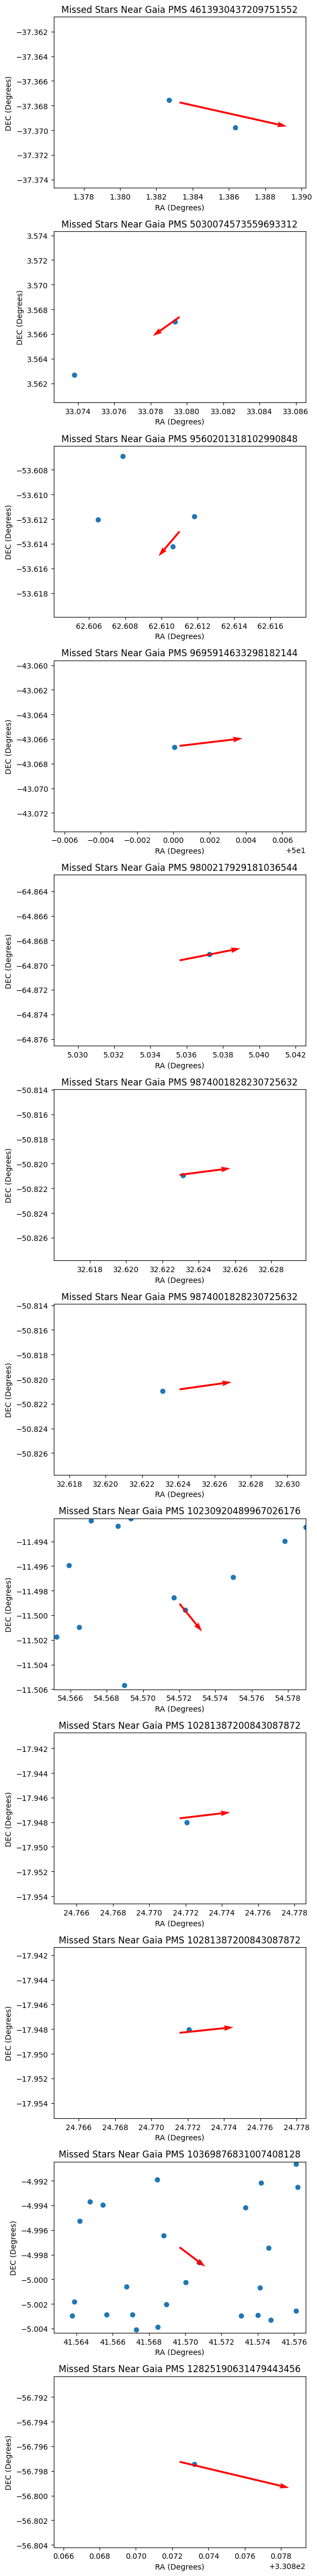

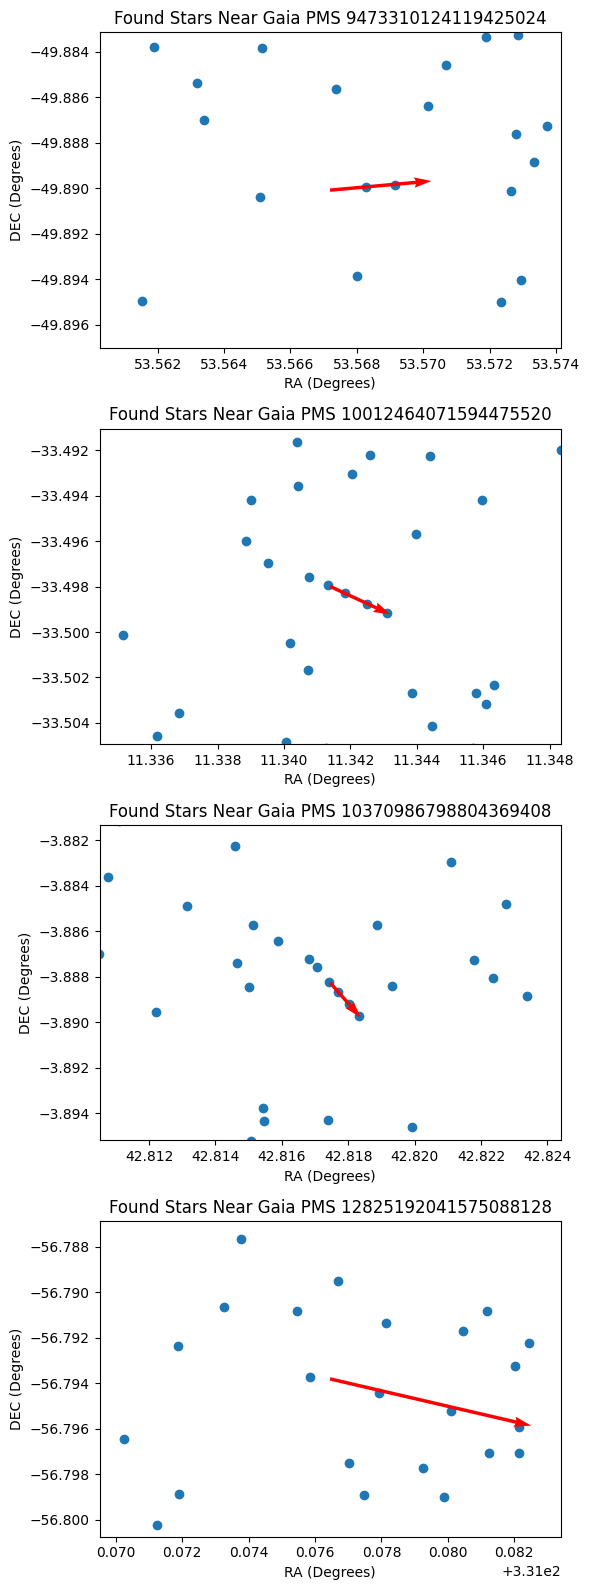

In [8]:
plot_missed_pms(df=df_no_dupes, check_column='algo_found', cone_search_rad=cone_search_rad)
plot_found_pms(df=df_no_dupes, check_column='algo_found', cone_search_rad=cone_search_rad)


In [16]:
#Manually added columns with Gaia Magnitudes in G, RP, BP from https://vizier.cds.unistra.fr/viz-bin/VizieR-4
df_with_gaia_mags = pd.read_csv('algo_gaia_verified.csv')

df_with_gaia_mags

,_hipscat_index,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,FLAGS_G_des,FLAGS_R_des,FLAGS_I_des,FLAGS_Z_des,...,pmra_gaia,dec_gaia,pmdec_gaia,parallax_over_error_gaia,_dist_arcsec,algo_found,source_id_gaia,GMag_gaia,BPmag_gaia,RPmag_gaia
0,4613930437209751552,0.845420,0.845421,0.845413,0.845344,0.035287,19,19,19,19,...,5633.438088,-37.367744,-2334.721273,6359.30100,1.786142,False,2306965202564744064,7.682494,8.802319,6.616270
1,5030074573559693312,0.844564,0.845075,0.845251,0.843732,0.801461,2,2,2,2,...,-1762.405718,3.567385,-1852.871100,3857.43380,1.620950,False,2515037264041041536,9.205841,10.280927,8.165198
2,9473310124119425024,0.048989,0.404167,0.994140,0.028650,0.028268,3,3,3,3,...,2360.592206,-49.890084,483.127504,2020.93920,2.582885,True,4736655036868019072,15.837138,19.476444,14.289389
3,9560201318102990848,0.125803,0.120065,0.028601,0.028627,0.028627,3,3,3,3,...,-825.179370,-53.612997,-2415.577565,6581.66400,4.490123,False,4780100658292046592,11.902864,13.809194,10.605541
4,9695914633298182144,0.845425,0.845425,0.845406,0.845371,0.845130,22,22,18,18,...,3035.017316,-43.066553,726.964482,2112.30930,0.825611,False,4847957293278177024,4.063915,4.440891,3.508293
5,9800217929181036544,0.844839,0.845014,0.845117,0.845267,0.844982,2,2,2,2,...,1706.746855,-64.869617,1164.959443,871.18390,3.096527,False,4900108950849461248,4.073510,4.369477,3.600201
6,9874001828230725632,0.845360,0.029197,0.845341,0.842975,0.047746,2,3,2,2,...,2125.416147,-50.820906,637.975043,2016.63440,0.425698,False,4937000898856156288,5.893562,6.311407,5.297973
7,9874001828230725632,0.845360,0.029197,0.845341,0.842975,0.047746,2,3,2,2,...,2168.886011,-50.820823,710.847727,588.37570,2.199757,False,4937000898856154624,13.088840,NaN,NaN
8,10012464071594475520,0.036971,0.466729,0.943789,0.983893,0.035059,3,3,3,3,...,1826.373986,-33.497993,-1485.010343,166.26512,4.295977,True,5006232026455470848,18.607740,19.310984,17.805714
9,10230920489967026176,0.030403,0.411389,0.028938,0.807518,0.029687,3,3,3,3,...,1458.200738,-11.499069,-2696.545125,2813.16020,2.138555,False,5115463180914712448,12.066338,13.255437,10.986762


Text(0.5, 1.0, 'RP band Magnitudes for Found HPMS in DES/Gaia Xmatch')

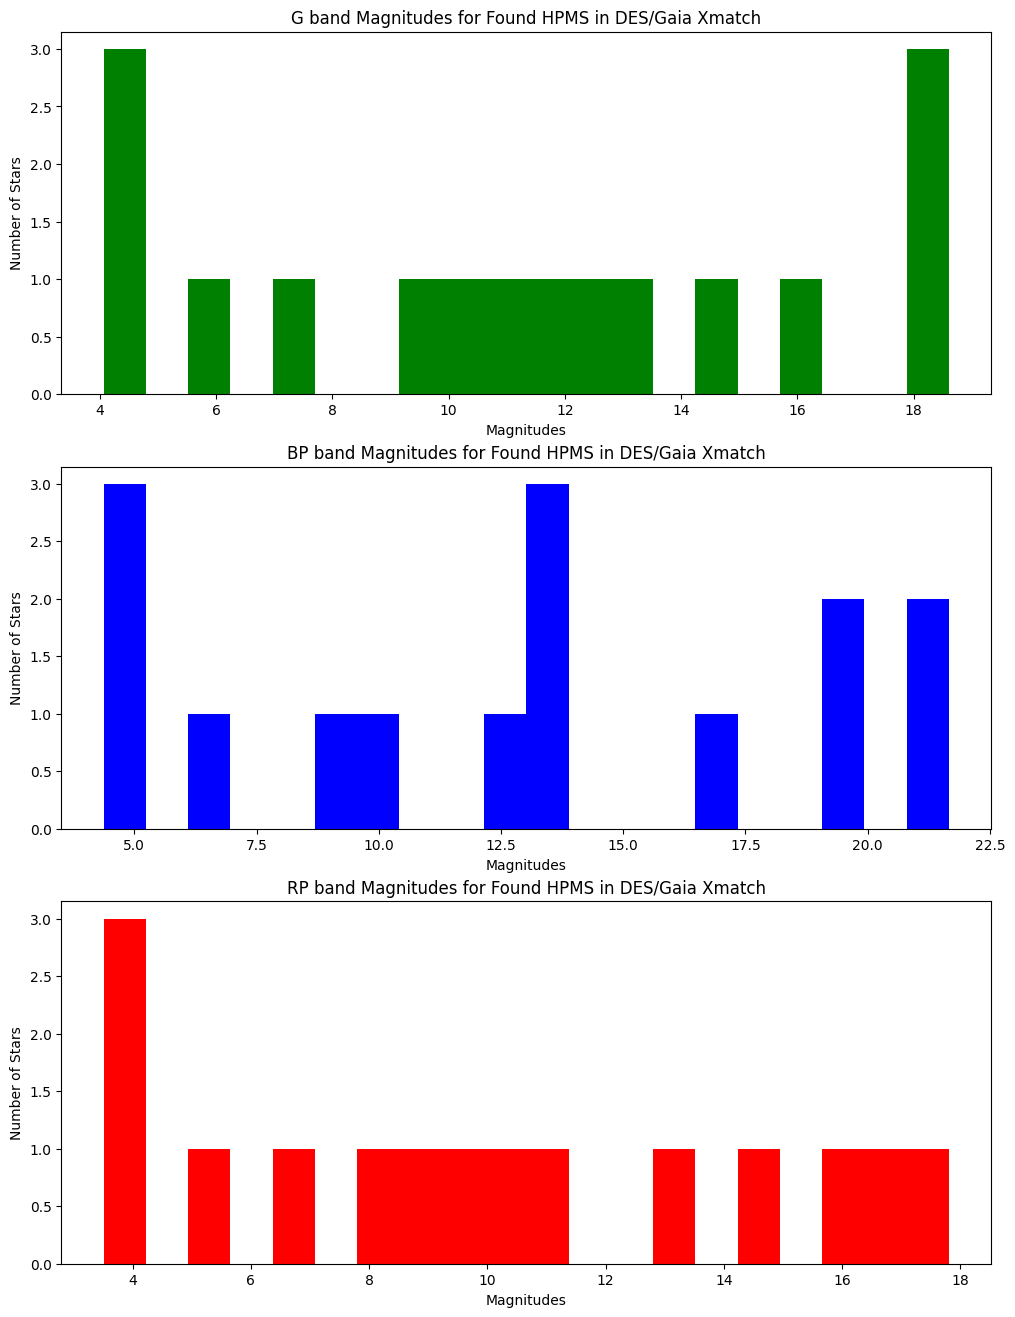

In [28]:
plt.figure(figsize=(12,16))

plt.subplot(3, 1, 1)
plt.hist(df_with_gaia_mags['GMag_gaia'], color='green', bins=20)
plt.xlabel('Magnitudes')
plt.ylabel('Number of Stars')
plt.title('G band Magnitudes for Found HPMS in DES/Gaia Xmatch')

plt.subplot(3, 1, 2)
plt.hist(df_with_gaia_mags['BPmag_gaia'], color='blue', bins=20)
plt.xlabel('Magnitudes')
plt.ylabel('Number of Stars')
plt.title('BP band Magnitudes for Found HPMS in DES/Gaia Xmatch')

plt.subplot(3, 1, 3)
plt.hist(df_with_gaia_mags['RPmag_gaia'], color='red', bins=20)
plt.xlabel('Magnitudes')
plt.ylabel('Number of Stars')
plt.title('RP band Magnitudes for Found HPMS in DES/Gaia Xmatch')

In [30]:
df_gaia_mag_filtered = df_with_gaia_mags.query('GMag_gaia > 14.5 and RPmag_gaia > 14.5 and BPmag_gaia > 14.5')
df_gaia_mag_filtered

,_hipscat_index,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,FLAGS_G_des,FLAGS_R_des,FLAGS_I_des,FLAGS_Z_des,...,pmra_gaia,dec_gaia,pmdec_gaia,parallax_over_error_gaia,_dist_arcsec,algo_found,source_id_gaia,GMag_gaia,BPmag_gaia,RPmag_gaia
8,10012464071594475520,0.036971,0.466729,0.943789,0.983893,0.035059,3,3,3,3,...,1826.373986,-33.497993,-1485.010343,166.26512,4.295977,True,5006232026455470848,18.607740,19.310984,17.805714
13,10370986798804369408,0.005172,0.982307,0.995200,0.994617,0.992330,3,3,3,3,...,1112.662482,-3.888260,-1853.859956,457.45987,3.949090,True,5185493447310441728,17.976585,21.664816,16.401794
15,12825192041575088128,0.027425,0.835557,0.952403,0.028126,0.036000,3,3,3,3,...,3981.976663,-56.793812,-2466.831815,392.50983,3.687586,True,6412596012146801152,18.030664,21.142073,16.060108


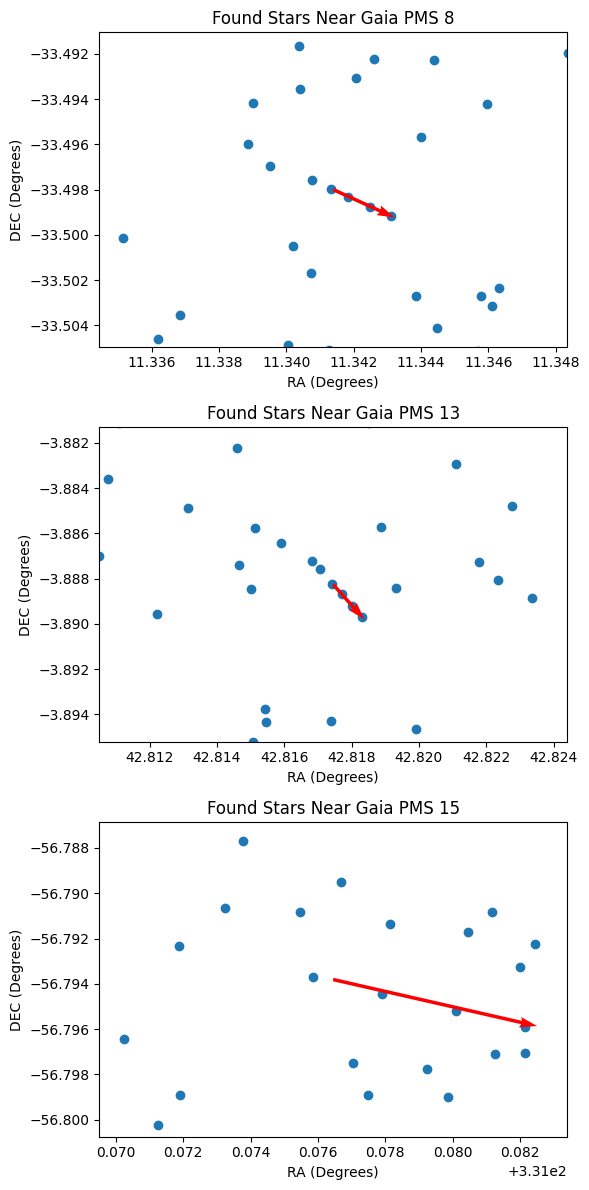

In [34]:
plot_found_pms(df=df_gaia_mag_filtered, check_column='algo_found', cone_search_rad=cone_search_rad)